# Backtesting investment strategies

## Setup

In [1]:
from ml_strategies.random_forest import strategy as random_forest_strategy
from quant_strategies.minimum_variance_portfolio import strategy as minimum_variance_portfolio_strategy 
import cloudpickle
import backtester
import helpers
import sys
from datetime import datetime

## Data download

In [2]:
equity_symbols = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "^GSPC"]

equity_returns = helpers.download_equity_returns(
    equity_symbols, 
    start_date=datetime.strptime('2017-01-01','%Y-%m-%d'), 
    end_date=datetime.strptime('2023-10-31','%Y-%m-%d'),
)
stock_returns = equity_returns.drop('^GSPC', axis=1)
index_returns = equity_returns.loc[:, ['^GSPC']]
sample_split_index = len(equity_returns) // 2
sample_split_date = index_returns.index[sample_split_index]

## Stock returns

In [3]:
helpers.display_as_percentage(stock_returns)

,AAPL,MSFT,GOOGL,AMZN,TSLA
2017-01-04,-0.11 %,-0.45 %,-0.03 %,0.47 %,4.61 %
2017-01-05,0.51 %,0.0 %,0.65 %,3.07 %,-0.11 %
2017-01-06,1.11 %,0.87 %,1.5 %,1.99 %,1.0 %
2017-01-09,0.92 %,-0.32 %,0.24 %,0.12 %,0.99 %
2017-01-10,0.1 %,-0.03 %,-0.14 %,-0.13 %,-0.61 %
...,...,...,...,...,...
2023-10-24,0.25 %,0.37 %,1.69 %,1.58 %,2.09 %
2023-10-25,-1.35 %,3.07 %,-9.51 %,-5.58 %,-1.89 %
2023-10-26,-2.46 %,-3.75 %,-2.65 %,-1.5 %,-3.14 %
2023-10-27,0.8 %,0.59 %,-0.09 %,6.83 %,0.75 %


## Quant strategy example

In [4]:
weights = backtester.run(strategy=minimum_variance_portfolio_strategy, test_data=stock_returns, start_date=sample_split_date)
report = backtester.analyze(minimum_variance_portfolio_strategy.name, weights, stock_returns.loc[sample_split_date:])

### Portfolio metrics

In [5]:
report.portfolio_metrics()

,Metric
Portfolio return,85.62
Portfolio volatility,27.78
Sharpe ratio,2.90


### Portfolio weights

In [6]:
helpers.display_as_percentage(report.portfolio_weights)

,AAPL,MSFT,GOOGL,AMZN,TSLA
2020-06-03,17.69 %,11.97 %,38.77 %,26.57 %,5.0 %
2020-06-04,17.75 %,11.94 %,38.67 %,26.64 %,5.0 %
2020-06-05,17.63 %,11.85 %,38.71 %,26.81 %,5.0 %
2020-06-08,17.64 %,11.89 %,38.74 %,26.73 %,5.0 %
2020-06-09,17.39 %,12.09 %,38.99 %,26.53 %,5.0 %
...,...,...,...,...,...
2023-10-24,25.23 %,31.08 %,30.89 %,7.8 %,5.0 %
2023-10-25,25.25 %,32.57 %,29.64 %,7.54 %,5.0 %
2023-10-26,25.32 %,32.32 %,29.68 %,7.68 %,5.0 %
2023-10-27,25.34 %,32.37 %,29.76 %,7.53 %,5.0 %


### Portfolio returns

#### Table

In [7]:
helpers.display_as_percentage(report.portfolio_returns)

,Value
2020-06-04,-1.28 %
2020-06-05,1.85 %
2020-06-08,1.2 %
2020-06-09,1.51 %
2020-06-10,2.14 %
...,...
2023-10-24,0.93 %
2023-10-25,-2.68 %
2023-10-26,-2.89 %
2023-10-27,0.92 %


#### Graph

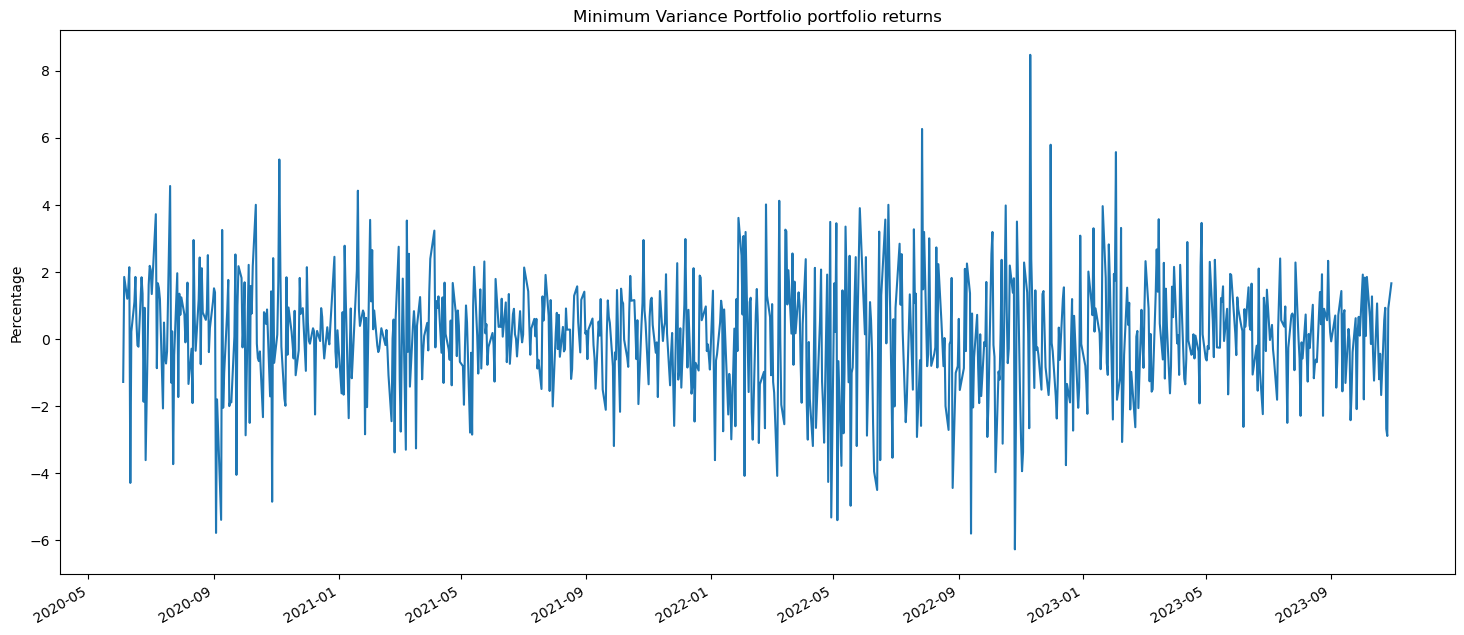

In [8]:
report.plot_portfolio_returns()

### Portfolio value

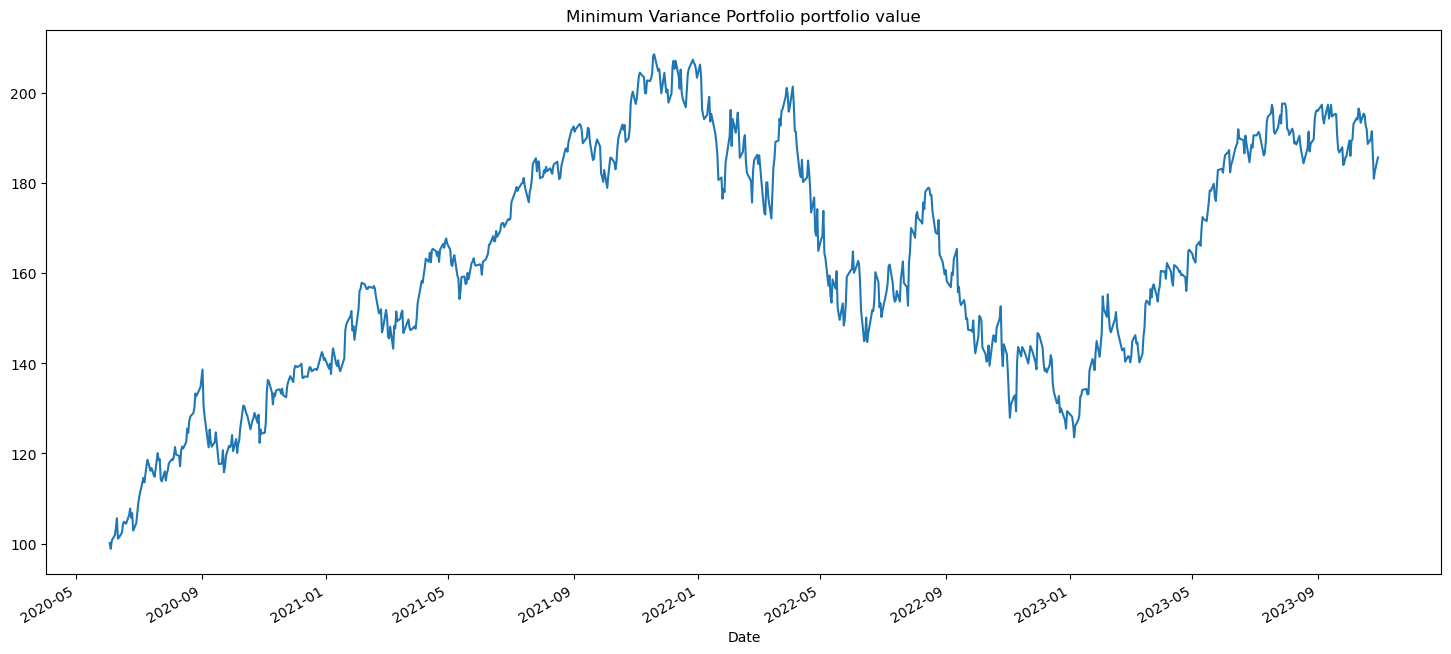

In [9]:
report.plot_portfolio_value()

### Portfolio value breakdown

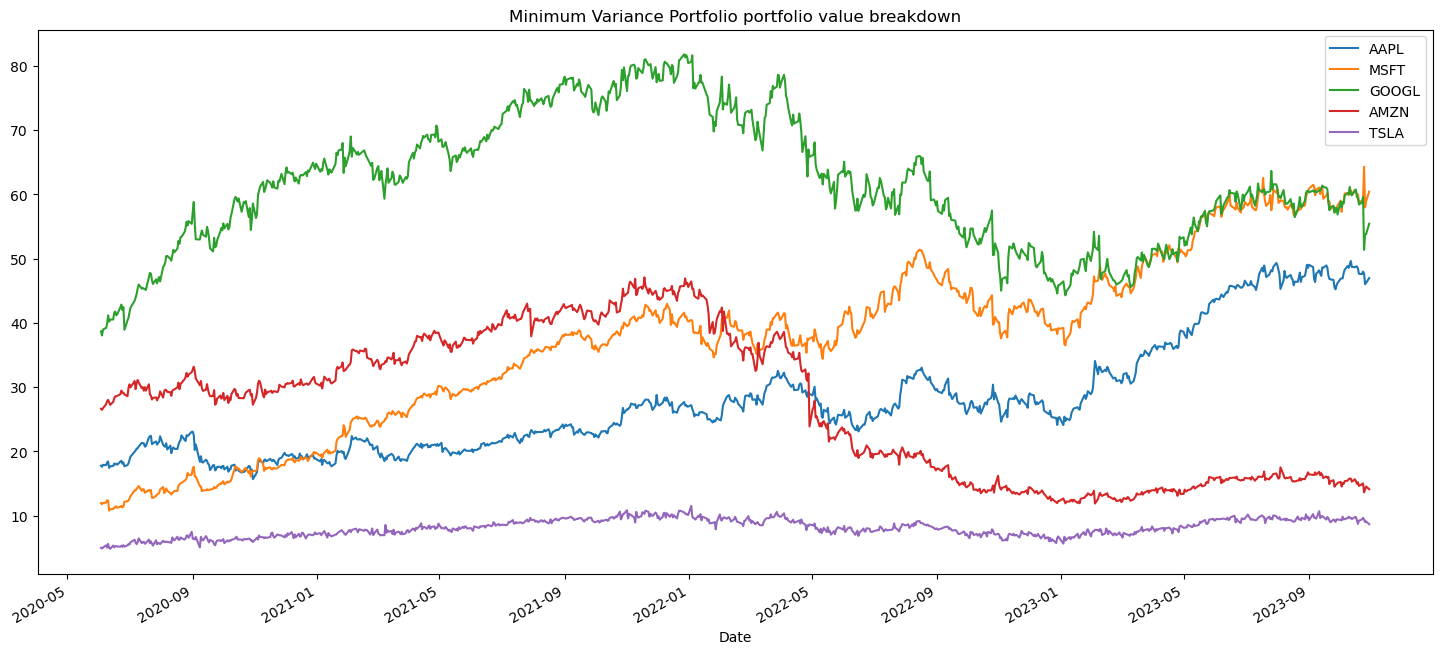

In [10]:
report.plot_portfolio_value_breakdown()

## Machine learning strategy example

In [11]:
y_training_data = stock_returns[:sample_split_index]
X_training_data = index_returns[:sample_split_index]

X_test_data = index_returns.loc[sample_split_date:]

random_forest_strategy.train(y=y_training_data, X=X_training_data)
random_forest_strategy.dump()

weights = backtester.run(random_forest_strategy, X_test_data, sample_split_date, window_size=1)
report = backtester.analyze(random_forest_strategy.name, weights, stock_returns.loc[sample_split_date:])

### Portfolio metrics

In [12]:
report.portfolio_metrics()

,Metric
Portfolio return,153.53
Portfolio volatility,33.73
Sharpe ratio,4.40


### Portfolio weights

In [13]:
helpers.display_as_percentage(report.portfolio_weights)

,AAPL,MSFT,GOOGL,AMZN,TSLA
2020-06-03,22.3 %,19.89 %,22.16 %,17.82 %,17.82 %
2020-06-04,8.82 %,8.82 %,8.82 %,8.82 %,64.74 %
2020-06-05,16.84 %,18.42 %,31.06 %,16.84 %,16.84 %
2020-06-08,21.43 %,17.14 %,17.14 %,17.14 %,27.14 %
2020-06-09,13.58 %,24.12 %,13.44 %,35.43 %,13.44 %
...,...,...,...,...,...
2023-10-24,11.83 %,12.11 %,11.83 %,11.83 %,52.39 %
2023-10-25,18.94 %,18.94 %,18.94 %,22.93 %,20.25 %
2023-10-26,21.82 %,18.36 %,19.77 %,27.84 %,12.21 %
2023-10-27,27.43 %,15.22 %,17.68 %,15.22 %,24.45 %


### Portfolio returns

#### Table

In [14]:
helpers.display_as_percentage(report.portfolio_returns)

,Value
2020-06-04,-1.77 %
2020-06-05,2.04 %
2020-06-08,2.58 %
2020-06-09,1.6 %
2020-06-10,4.82 %
...,...
2023-10-24,1.56 %
2023-10-25,-3.14 %
2023-10-26,-2.55 %
2023-10-27,1.51 %


#### Graph

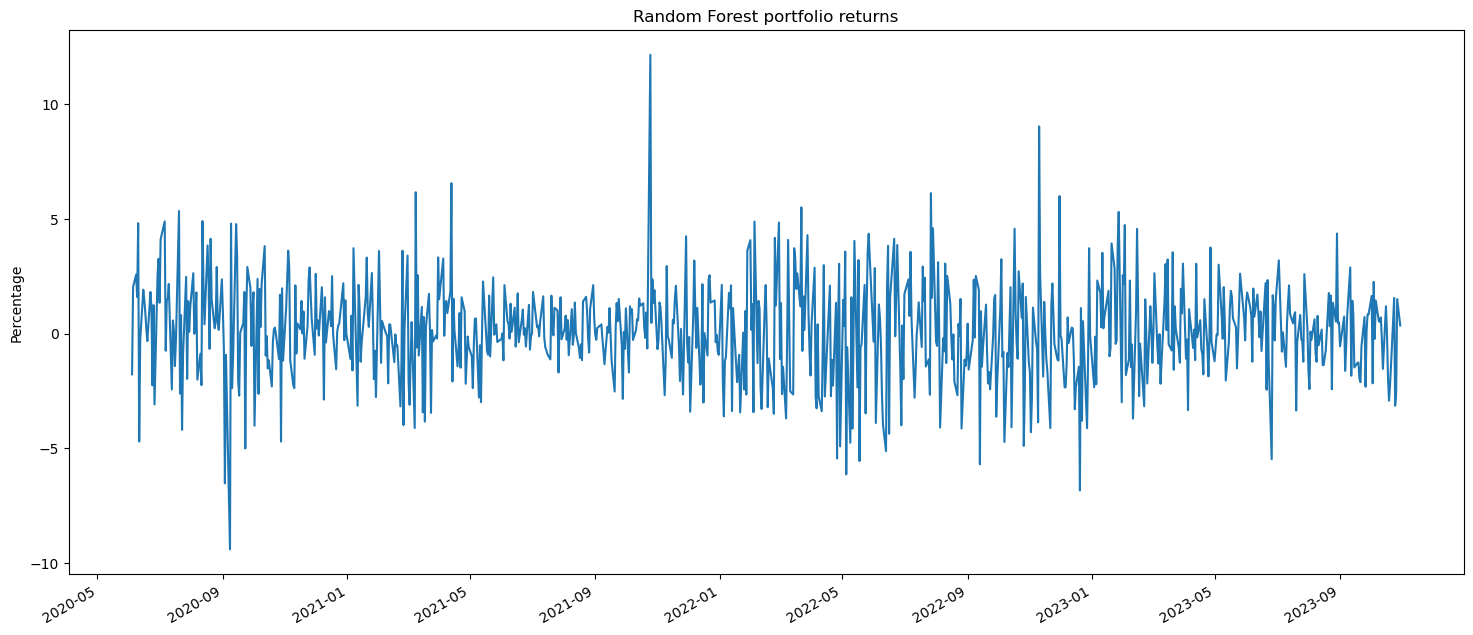

In [15]:
report.plot_portfolio_returns()

### Portfolio value

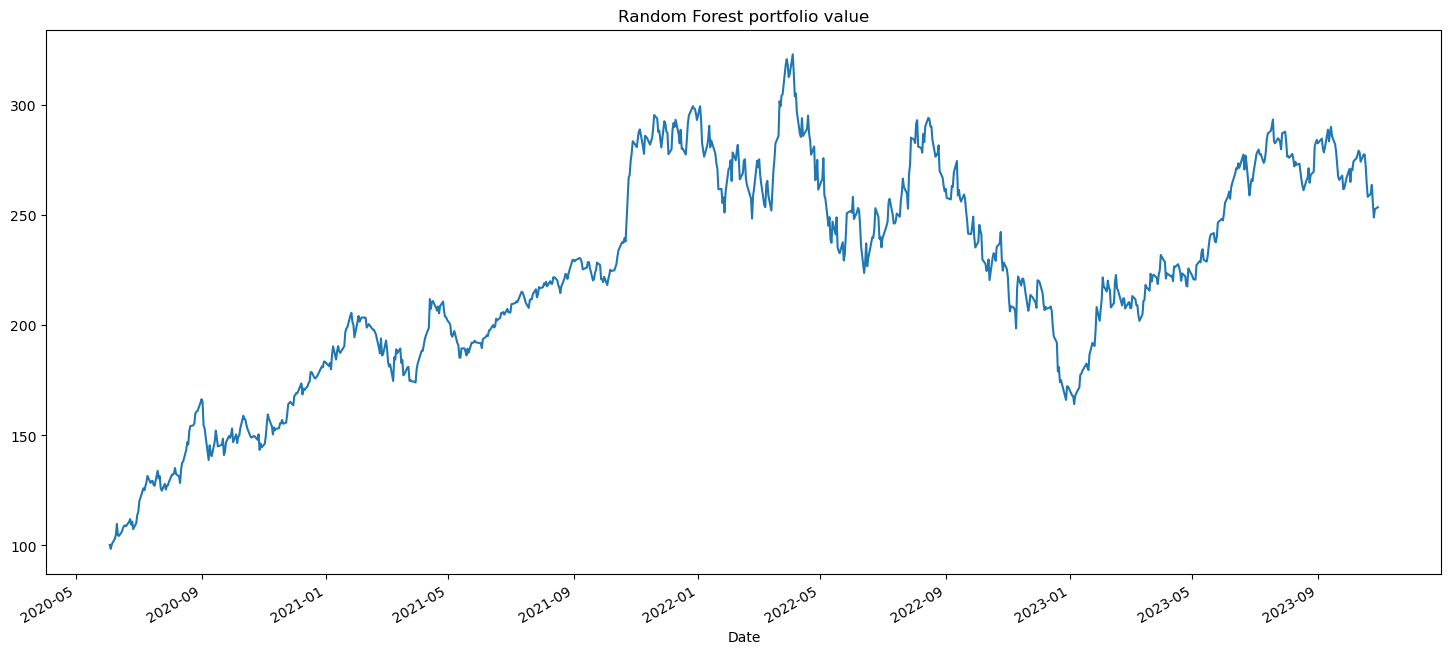

In [16]:
report.plot_portfolio_value()

### Portfolio value breakdown

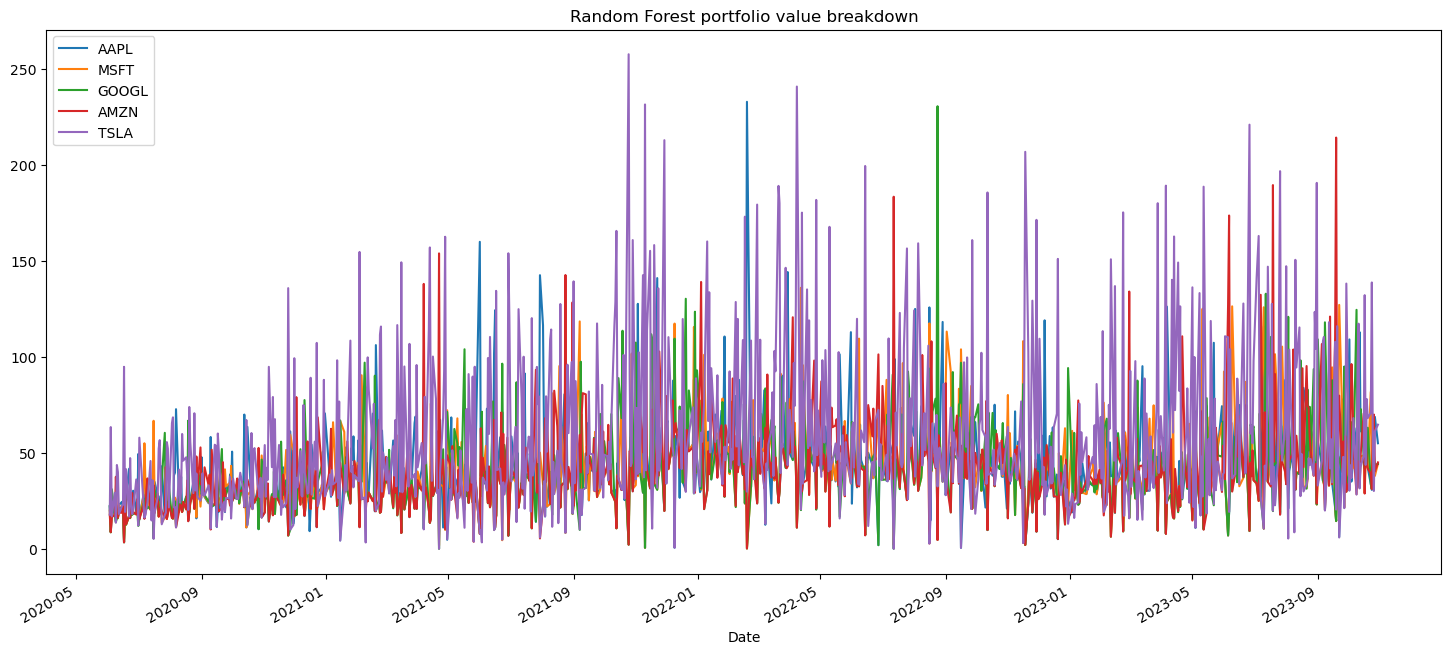

In [17]:
report.plot_portfolio_value_breakdown()